# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # either 3 or 6

from data_generators import *
from utils import *
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

torch.__version__

'1.8.1'

In [2]:
# setup generators / data loaders for training and validation

# we'll make the training data loader in the training loop,
# since we need to update some of the examples used each epoch
source_train_gen = TrainGenerator("mouse", "CTCF")
target_train_gen = TrainGenerator("human", "CTCF")

source_val_gen = ValGenerator("mouse", "CTCF")
# using a batch size of 1 here because the generator returns
# many examples in each batch
source_val_data_loader = DataLoader(source_val_gen, batch_size = 1, shuffle = False)

target_val_gen = ValGenerator("human", "CTCF")
target_val_data_loader = DataLoader(target_val_gen, batch_size = 1, shuffle = False) # why would shuffle=True mess with the results?

1365
1370


In [40]:
class BasicModel(torch.nn.Module):
    def __init__(self, alpha1=1., alpha2=0., summary_writer=None):
        super(BasicModel, self).__init__()
        self.input_seq_len = 500
        num_conv_filters = 240
        lstm_hidden_units = 32
        fc_layer1_units = 1024
        fc_layer2_units = 512
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        
        
        # Defining the layers to go into our model
        # (see the forward function for how they fit together)
        self.conv = torch.nn.Conv1d(4, num_conv_filters, kernel_size=20, padding=0)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(15, stride=15, padding=0)
        self.lstm = torch.nn.LSTM(input_size=num_conv_filters,
                                  hidden_size=lstm_hidden_units,
                                  batch_first=True)
        self.fc1 = torch.nn.Linear(in_features=lstm_hidden_units,
                                   out_features=fc_layer1_units)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(in_features=fc_layer1_units,
                                   out_features=fc_layer2_units)
        self.fc_final = torch.nn.Linear(in_features=fc_layer2_units,
                                        out_features=1)
        self.sigmoid = torch.nn.Sigmoid()
        
        self.BCE_loss = torch.nn.BCELoss()

        # We'll store performance metrics during training in these lists
        self.train_loss_by_epoch = []
        self.train_BCE_loss_by_epoch = []
        self.train_CORAL_loss_by_epoch = []
        self.source_val_loss_by_epoch = []
        self.source_val_auprc_by_epoch = []
        self.target_val_loss_by_epoch = []
        self.target_val_auprc_by_epoch = []

        # We'll record the best model we've seen yet each epoch
        self.best_state_so_far = self.state_dict()
        self.best_auprc_so_far = 1

        # self.norm_diff = lambda A, B: [torch.linalg.norm(a - b) for (a,b) in zip(A,B)]
        # self.cov = lambda data: torch_cov(torch.max(self.conv(data.squeeze().cuda()), 2).values.T)
    
    def covariance(self, data):
        # let's hope that this pytorch implementation of torch_cov is differentiable
        # see utils.py
        return torch_cov(torch.max(self.conv(data.squeeze().cuda()), 2).values.T)
    
    def norm_diff(self, A, B):
        return torch.linalg.norm(A - B, axis=1)
    
    def loader_to_generator(self, data_loader):
        for batch in data_loader:
            yield batch
        # TODO check that each batch is the same as previous

    def CORAL_loss(self, src_batch, tgt_gen, convolve):
        # TODO need to handle case where we have more source than target data and next() returns None
        tgt_batch, tgt_labels = next(tgt_gen)
        a = self.covariance(src_batch) #, self.conv)
        b = self.covariance(tgt_batch) #, self.conv)
        d = a.shape[0]
        loss = self.norm_diff(a, b) / (4 * d * d)
#         loss = torch.tensor(self.norm_diff(a, b)).cuda() / (4 * d * d)
        return torch.sum(loss) # TODO sum? mean?
        
    def forward(self, X):
        # return (self.conv(X))
        X_1 = self.relu(self.conv(X))
        # LSTM is expecting input of shape (batches, seq_len, conv_filters)
        X_2 = self.maxpool(X_1).permute(0, 2, 1)
        X_3, _ = self.lstm(X_2)
        X_4 = X_3[:, -1]  # only need final output of LSTM
        X_5 = self.relu(self.fc1(X_4))
        X_6 = self.dropout(X_5)
        X_7 = self.sigmoid(self.fc2(X_6))
        y = self.sigmoid(self.fc_final(X_7)).squeeze()
        return y
    
    def validation(self, data_loader): 
        # only run this within torch.no_grad() context!
        losses = []
        preds = []
        labels = []
        for seqs_onehot_batch, labels_batch in tqdm(data_loader):
            # push batch through model, get predictions, calculate loss
            preds_batch = self(seqs_onehot_batch.squeeze().cuda())
            labels_batch = labels_batch.squeeze()
            loss_batch = self.BCE_loss(preds_batch, labels_batch.cuda())
            losses.append(loss_batch.item())

            # storing labels + preds for auPRC calculation later
            labels.extend(labels_batch.detach().numpy())  
            preds.extend(preds_batch.cpu().detach().numpy())
            
        return np.array(losses), np.array(preds), np.array(labels)

    def CORAL_loss_validation(self, source_val_data_loader, target_val_data_loader):
        losses = []
        tgt_gen = self.loader_to_generator(target_val_data_loader)
        
        for seqs_onehot_batch, labels_batch in tqdm(source_val_data_loader):
            loss_batch = CORAL_loss(seqs_onehot_batch, tgt_gen, self.conv)
            losses.append(loss_batch)
        return torch.tensor(losses)
    
#         src_gen = loader_to_generator(source_val_data_loader)
#         tgt_gen = loader_to_generator(target_val_data_loader)
#         src_batch,_ = next(src_gen)
#         tgt_batch,_ = next(tgt_gen)
#         while src_batch is not None and tgt_batch is not None:
#             CORAL_loss_batch = self.alpha * CORAL_loss(src_batch.squeeze().cuda(), self.conv)
#             CORAL_losses.append(CORAL_loss_batch.item())
#             src_batch,_ = next(src_gen)
#             tgt_batch,_ = next(tgt_gen)
    
    def fit(self, source_train_gen, target_train_gen, source_val_data_loader, target_val_data_loader,
            optimizer, epochs=15):
        print(f'Training for {epochs} epochs')
        CORAL_loss_all = []
        for epoch in tqdm(range(epochs)):
            torch.cuda.empty_cache()  # clear memory to keep stuff from blocking up
            
            print("=== Epoch " + str(epoch + 1) + " ===")
            print("Training...")
            self.train()
            
            # using a batch size of 1 here because the generator returns
            # many examples in each batch
            source_train_data_loader = DataLoader(source_train_gen,
                               batch_size = 1, shuffle = True)
            target_train_data_loader = DataLoader(target_train_gen,
                               batch_size = 1, shuffle = True)
            
            # returns the next batch of shuffled human data
            target_train_data_generator = self.loader_to_generator(target_train_data_loader)

            train_losses = []
            train_BCE_losses = []
            train_CORAL_losses = []
            train_preds = []
            train_labels = []
            for batch_i, data in enumerate(tqdm(source_train_data_loader)):
#                 for p in model.parameters():
#                     print(p)
                seqs_onehot_batch, labels_batch = data
                
                # reset the optimizer; need to do each batch after weight update
                optimizer.zero_grad()

                # push batch through model, get predictions, and calculate loss
                preds = self(seqs_onehot_batch.squeeze().cuda())
                labels_batch = labels_batch.squeeze()
                BCE_loss_batch = self.BCE_loss(preds, labels_batch.cuda())
                CORAL_loss_batch = self.CORAL_loss(seqs_onehot_batch, target_train_data_generator, self.conv)
#                 CORAL_loss_batch.requires_grad=True

                # backpropagate the loss and update model weights accordingly
                total_loss_batch = CORAL_loss_batch # BCE_loss_batch # 
#                 total_loss_batch = self.alpha1 * BCE_loss_batch + self.alpha2 * CORAL_loss_batch
#                 print('total loss:', total_loss)
#                 print(f'BCE: {BCE_loss_batch}, CORAL: {CORAL_loss_batch}')
#                 CORAL_loss_batch.backward()
                total_loss_batch.backward()
                optimizer.step()
                
                train_losses.append(total_loss_batch.item())
                train_BCE_losses.append(BCE_loss_batch.item())
                train_CORAL_losses.append(CORAL_loss_batch.item())
                train_labels.extend(labels_batch)
                train_preds.extend(preds.cpu().detach().numpy())
#                 summary_writer.add_scalar("Loss/train/CORAL", CORAL_loss_batch.item(), batch_i + epoch * 400) # 400 is batch size for train TODO get rid of magic number
#                 summary_writer.add_scalar("Loss/train/BCE", BCE_loss_batch.item(), batch_i + epoch * 400) # 400 is batch size for train TODO get rid of magic number
#                 summary_writer.add_scalar("Loss/train/total", total_loss_batch.item(), batch_i + epoch * 400) # 400 is batch size for train TODO get rid of magic number

#                 print('train CORAL loss:', train_CORAL_losses[-1])
#                 if batch_i > BREAK_AFTER:
#                     break
            CORAL_loss_all.extend(train_CORAL_losses)
            self.train_loss_by_epoch.append(np.mean(train_losses))
            self.train_BCE_loss_by_epoch.append(np.mean(train_BCE_losses))
            self.train_CORAL_loss_by_epoch.append(np.mean(train_CORAL_losses))
            
            print(f'avg total loss: {self.train_loss_by_epoch[-1]}')
            print(f'avg BCE   loss: {self.train_BCE_loss_by_epoch[-1]}')
            print(f'avg CORAL loss: {self.train_CORAL_loss_by_epoch[-1]}')
            
            print_metrics(train_preds, train_labels)
            
            # load new set of negative examples for next epoch
            source_train_gen.on_epoch_end()
            
            # TODO plot train CORAL loss by batches ?        
#             summary_writer.flush()
            
            # Since we don't use gradients during model evaluation,
            # the following two lines let the model predict for many examples
            # more efficiently (without having to keep track of gradients)
#             return CORAL_loss_all
            
            continue
            
            self.eval()
            with torch.no_grad():
                # Assess model performance on same-species validation set
                print("\nEvaluating on source validation data...")
                
                source_val_losses, source_val_preds, source_val_labels = self.validation(source_val_data_loader)

                print("Source validation loss:", np.mean(source_val_losses))
                self.source_val_loss_by_epoch.append(np.mean(source_val_losses))

                # calc auPRC over source validation set
                source_val_auprc = print_metrics(source_val_preds, source_val_labels)
                self.source_val_auprc_by_epoch.append(source_val_auprc)

                # check if this is the best performance we've seen so far
                # if yes, save the model weights -- we'll use the best model overall
                # for later analyses
                if source_val_auprc < self.best_auprc_so_far:
                    self.best_auprc_so_far = source_val_auprc
                    self.best_state_so_far = self.state_dict()
                
                
                # now repeat for target species data 
                print("\nEvaluating on target validation data...")
                
                target_val_losses, target_val_preds, target_val_labels = self.validation(target_val_data_loader)

                print("Target validation loss:", np.mean(target_val_losses))
                self.target_val_loss_by_epoch.append(np.mean(target_val_losses))

                # calc auPRC over source validation set
                target_val_auprc = print_metrics(target_val_preds, target_val_labels)
                self.target_val_auprc_by_epoch.append(target_val_auprc)
                
            print(f'End of epoch {epoch + 1}')
        
        return CORAL_loss_all # , BCE_loss_all, total_loss_all # after all epochs end
        


In [41]:
# %%capture cap --no-stderr
ALPHA1 = 1
ALPHA2 = 0.076923077
LR     = 1e-3
BREAK_AFTER = 10
print(f'  LR={LR}\n  alpha1={ALPHA1} (BCE),\n  alpha2={ALPHA2} (CORAL)')
# summary_writer = SummaryWriter()
model = BasicModel(alpha1=ALPHA1, alpha2=ALPHA2, summary_writer=None) # 0, 100_000_000, np.inf
model.load_state_dict(torch.load('../models/baseline'))
# model = BasicModel() # setting alphas in the code for now
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# model.load_state_dict( torch.load('../models/baseline'))
model.cuda()
CORAL_loss_all = model.fit(source_train_gen, target_train_gen, source_val_data_loader, target_val_data_loader, optimizer, epochs = 1)
model.cpu()
# summary_writer.close()

timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')
run_name = f'coral-{timestamp}-lr_{LR}-alpha_{ALPHA2}'
torch.save(model.state_dict(), '../models/' + run_name)
# with open(f'../logs/coral-alpha_{ALPHA}_{timestamp}.txt', 'w') as file:
#     file.write(cap.stdout)

  LR=0.001
  alpha1=1 (BCE),
  alpha2=0.076923077 (CORAL)
Training for 1 epochs


  0%|          | 0/1 [00:00<?, ?it/s]

=== Epoch 1 ===
Training...


  0%|          | 0/1365 [00:00<?, ?it/s]

avg total loss: 3.7117059925860592e-06
avg BCE   loss: 2.667461492585175
avg CORAL loss: 3.7117059925860592e-06
Loss:	 2.6674615475799976
auROC:	 0.5387398766520415
auPRC:	 0.5269271016971562
Confusion Matrix (at t = 0.5):
 [[  2248 270752]
 [    76 272924]]


-1.3554685587319126e-08

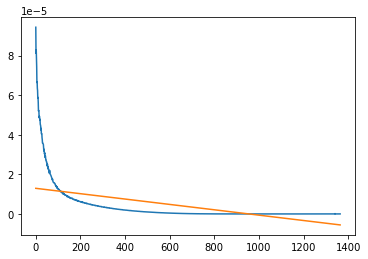

In [52]:
def plot_loss(loss, run_name):
    plt.plot(loss)
    y = loss
    x = range(len(loss))
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b)
    plt.savefig('../figures/' + run_name + '.jpg')
    return m

plot_loss(CORAL_loss_by_epoch, run_name)


In [49]:
# print(model.conv.weight.grad)
timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')
print(timestamp)
run_name = f'coral-{timestamp}_alpha_{ALPHA2}'

20211207T161219


In [13]:
# TEST tqdm
# import time
# d = {0:1, 1:2, 2:3, 3:4, 4:5}
# l = [(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)]
# def fn():
#     for k,v in tqdm(l):
#         time.sleep(0.1)

# for i in tqdm(range(20)):
#     fn()

# %%capture cap --no-stderr
# print('yay')